In [1]:
#!/usr/bin/env python3

import numpy as np
import matplotlib.pyplot as plt
import random as rd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state
from scipy.stats import multivariate_normal

In [2]:
def pdf_r(r, sigma):
    """Pdf for the log of eigenvalues of a SPD matrix.
        Probability deπnsity function for the logarithm of the eigenvalues of a SPD
        matrix samples from the Riemannian Gaussian distribution. See Said et al.
        "Riemannian Gaussian distributions on the space of symmetric positive
        definite matrices" (2017) for the mathematical details.
        Parameters
        ----------
        r : ndarray, shape (n_dim,)
            Vector with the logarithm of the eigenvalues of a SPD matrix.
        sigma : float
            Dispersion of the Riemannian Gaussian distribution.
        Returns
        -------
        p : float
            Probability density function applied to data point r.
        """
    if (sigma <= 0):
        raise ValueError(f'sigma must be a positive number (Got {sigma})')

    n_dim = len(r)
    partial_1 = -np.sum(r**2) / (2 * sigma**2)
    partial_2 = 0
    for i in range(n_dim):
        for j in range(i + 1, n_dim):
            partial_2 = partial_2 + np.log(np.sinh(np.abs(r[i] - r[j]) / 2))

    return np.exp(partial_1 + partial_2)


In [3]:
def _sample_parameter_U(n_samples, n_dim, random_state=None):
    """Sample the U parameters of a Riemannian Gaussian distribution.
    Sample the eigenvectors of a SPD matrix following a Riemannian Gaussian
    distribution.
    See https://arxiv.org/pdf/1507.01760.pdf for the mathematical details.
    Parameters
    ----------
    n_samples : int
        How many samples to generate.
    n_dim : int
        Dimensionality of the SPD matrices to be sampled.
    random_state : int, RandomState instance or None, default=None
        Pass an int for reproducible output across multiple function calls.
    Returns
    -------
    u_samples : ndarray, shape (n_samples, n_dim)
        Samples of the U parameters of the Riemannian Gaussian distribution.
    """

    u_samples = np.zeros((n_samples, n_dim, n_dim))
    rs = check_random_state(random_state)
    for i in range(n_samples):
        A = rs.randn(n_dim, n_dim)
        Q, _ = np.linalg.qr(A)
        u_samples[i] = Q

    return u_samples

print(_sample_parameter_U(1, 3)[0])

[[-0.09924203 -0.06370068 -0.99302228]
 [ 0.09028629 -0.99440888  0.05476647]
 [-0.99095883 -0.08422116  0.10443846]]


In [4]:
def pdf_joint_norm_dis(r, sigma):
    D = len(r)
    S = np.eye(D) * (sigma**2)
    x = 1/(2 * np.pi)**(D/2)
    x *= 1/np.linalg.det(S)**(1/2)
    x *= np.exp(-1/2 * np.dot(np.transpose(r), np.dot(np.linalg.inv(S), r)))
    return x

print(pdf_joint_norm_dis(np.array([1,2]), 1))
print(pdf_r(np.array([1]), 1))

0.013064233284684921
0.6065306597126334


In [2]:
def rejection_sampling_A(sigma, r):
    mua = np.array([sigma**2/2, -sigma**2/2])
    cov_matrix = np.eye(2)*sigma**2
    if r[0] >= r[1]:
        num = np.exp(-1/(2*sigma**2) * np.sum(r**2)) * np.sinh((r[0] - r[1])/2) * 1/M
        den = multivariate_normal.pdf(r, mean=mua, cov=cov_matrix)
        return num / den
    else:
        return 0

In [6]:
def rejection_sampling_B(sigma, r):
    mub = np.array([-sigma**2/2, sigma**2/2])
    cov_matrix = np.eye(2)*sigma**2
    if r[0] < r[1]:
        M = np.pi*(sigma**2)*np.exp(sigma**2/4)
        num = np.exp(-1/(2*sigma**2) * np.sum(r**2)) * np.sinh((r[1] - r[0])/2)
        den = multivariate_normal.pdf(r, mean=mub, cov=cov_matrix)*M
        return num/den
    return 0

In [306]:
# def rejection_sampling(sigma, n):
#     M = np.pi*(sigma**2)*np.exp(sigma**2/4)
#     mua = np.array([(sigma**2)/2, -(sigma**2)/2])
#     mub = np.array([-(sigma**2)/2, (sigma**2)/2])
#     cov_matrix= (sigma**2)*np.eye(2)
#     B = np.random.binomial(1, 0.5, n)
#     R1 = multivariate_normal.rvs(mua, cov_matrix, sum(B))
#     R2 = multivariate_normal.rvs(mub, cov_matrix, n-sum(B))
#     U1 = np.random.rand(sum(B))
#     U2 = np.random.rand(n-sum(B))
#     k = 0
#     l = 0
#     RES1 = []
#     RES2 = []
#     for i in range(n):
#         if B[i] == 1:
#             res = rejection_sampling_A(sigma, R1[k])
#             k+=1
#             RES1.append(res)
#         else:
#             res = rejection_sampling_B(sigma, R2[l])
#             l+=1
#             RES2.append(res)
#     cpt = 0
#     COUPLE1 = R1[U1<RES1]
#     COUPLE2 = R2[U2<RES2]
#     return np.concatenate([COUPLE1, COUPLE2])


In [7]:
def rejection_sampling(sigma, n):
    M = np.pi*(sigma**2)*np.exp(sigma**2/4)
    mua = np.array([(sigma**2)/2, -(sigma**2)/2])
    mub = np.array([-(sigma**2)/2, (sigma**2)/2])
    cov_matrix= (sigma**2)*np.eye(2)
    RES1 = []
    RES2 = []
    cpt = 0
    while cpt != n:
        if np.random.binomial(1, 0.5, 1) == 1:
            r = multivariate_normal.rvs(mua, cov_matrix, 1)
            res = rejection_sampling_A(sigma, r)
            if np.random.rand(1) < res:
                RES1.append(r)
                cpt += 1
        else:
            r = multivariate_normal.rvs(mub, cov_matrix, 1)
            res = rejection_sampling_B(sigma, r)
            if np.random.rand(1) < res:
                RES2.append(r)
                cpt+=1
    return np.concatenate([RES1, RES2])


In [10]:
R = rejection_sampling(1, 10000)
print(np.shape(R))

(10000, 2)


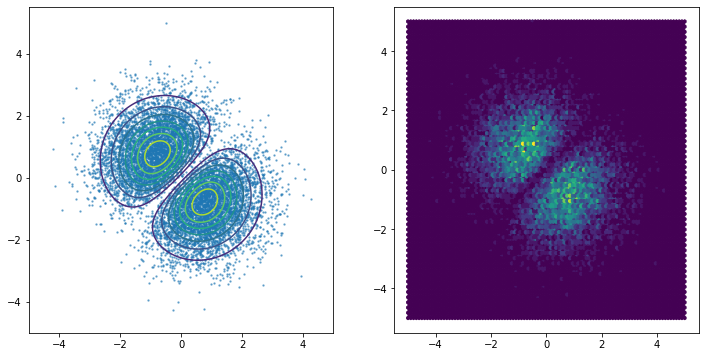

In [323]:
T = 5
rx = np.linspace(-T, T, 200)
ry = np.linspace(-T, T, 200)
RX, RY = np.meshgrid(rx, ry)

F = np.exp(-1/(2*sigma**2)*(RX**2 + RY**2)) * np.sinh(np.abs(RX - RY)/2)

fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
ax[0].contour(RX, RY, F)
ax[0].scatter(R[:,0],R[:,1], s=2, alpha=0.5)
ax[1].hexbin(R[:,0], R[:,1], extent=(-T, T, -T, T))
plt.show()

In [160]:
mua = np.array([(sigma**2)/2, -(sigma**2)/2])
mub = np.array([-(sigma**2)/2, (sigma**2)/2])
cov_matrix= (sigma**2)*np.eye(2)
R1 = multivariate_normal.rvs(mua, cov_matrix, 10)
print(R1)
print(R1[1])

[[ 0.09537905 -2.12399518]
 [ 1.42996774  0.85833585]
 [ 0.30961754  0.28584718]
 [ 0.50791223  0.17583654]
 [ 1.31939464 -1.14864422]
 [ 0.86360126  0.31870013]
 [-0.46690865 -0.52349492]
 [ 0.78212811  0.6500234 ]
 [ 1.26041188 -0.13015575]
 [ 0.53264852 -1.62767202]]
[1.42996774 0.85833585]
